# Forecast with LSTM

In [39]:
# Some imports and settings first..

%env KERAS_BACKEND=tensorflow
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
import pandas as pd
import numpy as np
import glob
import json
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

env: KERAS_BACKEND=tensorflow


## Load data

In [2]:
# load all csv files of North-point site. Concatenate them..
data_src = "../data"
data_dst = "../output"
all_files = glob.glob(os.path.join(data_src, "np", "*.csv"))
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)

# minor changes
df = df.rename(columns={"Time Stamp": "timestamp"})
df = df.replace("\\N", np.nan)

# update data types. object is taken as default
dtypes = dict([(col, np.float64) for col in df.columns])
dtypes["timestamp"] = "datetime64[ns]"
df = df.astype(dtypes)

# change the index to timestamp.
df.index = df.timestamp

C:\Anaconda2\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Anaconda2\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (4,8,12,18,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Anaconda2\envs\py3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (2,3,4,6,7,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


The key parameters under investigation are

- cwshdr := Condenser Water Supply Header (CWS-HDR)

- loadsys := Cooling Load (load sys)

- wetbulb := Wet bulb temperature

- ct1kw, ct2kw, ct3kw := Power of cooling tower (CT-KW)

## Visualize

(26, 32)

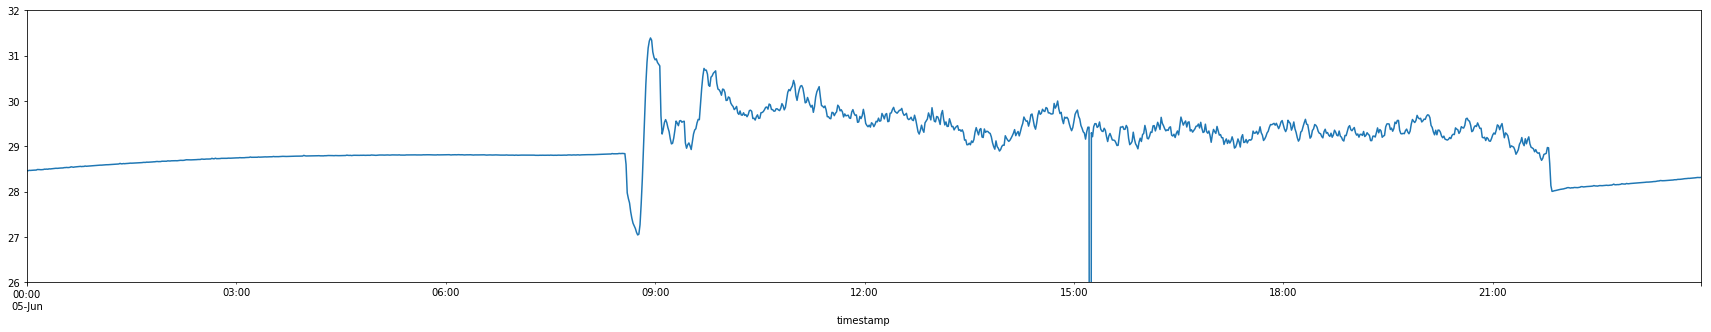

In [6]:
# Let's take a sample of the data and visualize the key parameters.
sample = df["2017-06-05": "2017-06-05"]
sample = sample[ ["cwshdr", "loadsys", "wetbulb", "ct1kw", "ct2kw", "ct3kw"] ].dropna()

plt.figure(figsize=(30,5))
ax = sample.cwshdr.plot()
ax.set_ylim(26, 32)

(26, 32)

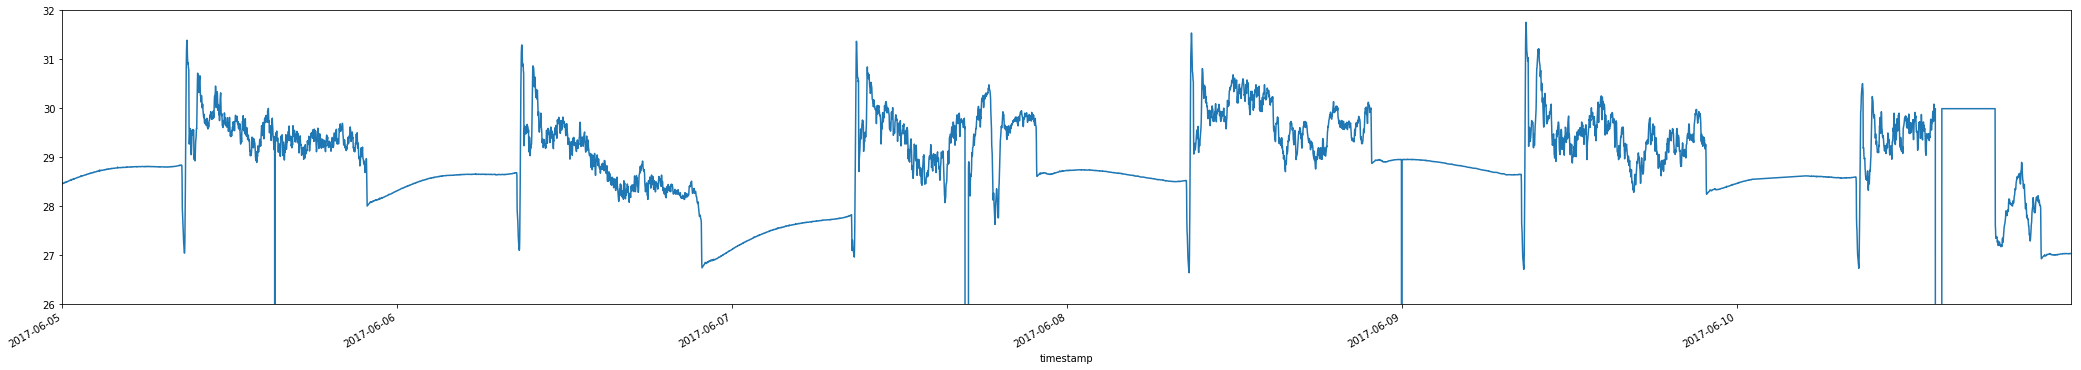

In [9]:
sample = df["2017-06-05":"2017-06-10"]
plt.figure(figsize=(36,6))
ax = sample.cwshdr.dropna().plot()
ax.set_ylim(26, 32)

In [14]:
df.timestamp.describe()

2016-08-13 13:35:00
2017-07-10 23:59:00


count                  440122
unique                 440122
top       2017-05-17 08:50:00
freq                        1
first     2016-08-13 13:35:00
last      2017-07-10 23:59:00
Name: timestamp, dtype: object

## Model

In [56]:
# Let's any continuous 2-months data and predit the following month..
test = df["2017-01-01":"2017-03-01"]
train = df["2017-03-02":"2017-03"]

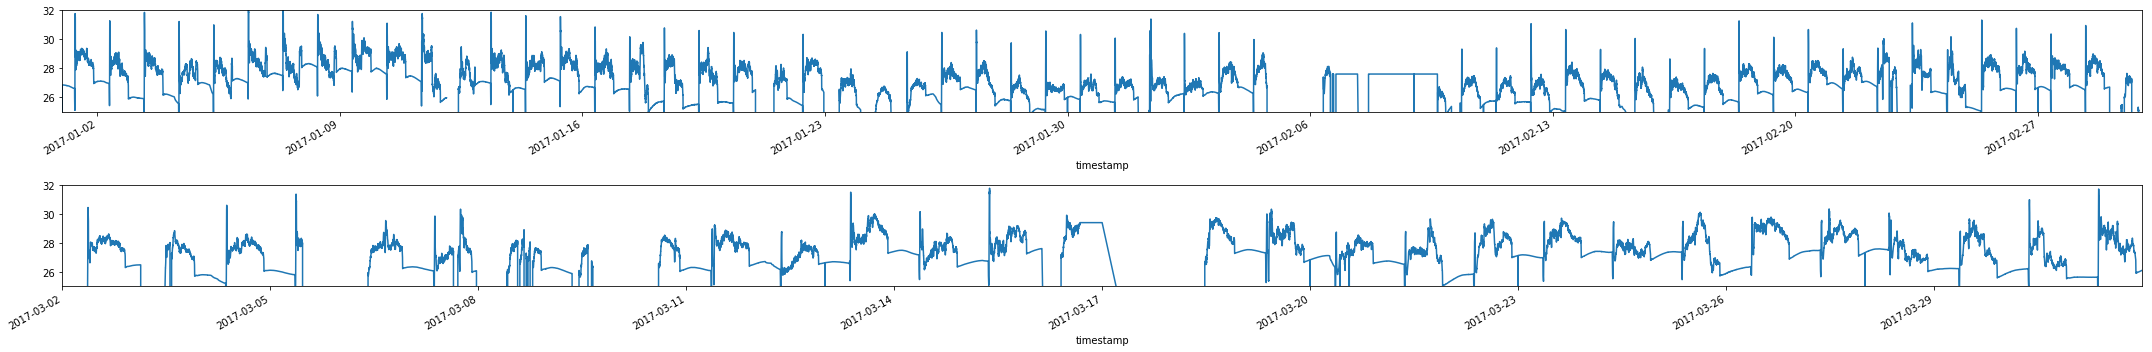

In [38]:
# Let's glance at the training and test data..
f, (a0, a1) = plt.subplots(2,1, figsize=(30,5))
test.cwshdr.plot(ax=a0)
train.cwshdr.plot(ax=a1)
a0.set_ylim(25,32)
a1.set_ylim(25,32)
f.tight_layout()

Note: 

1) Need to identify a suitable way to handle NaN and 0 values One approach is use moving average to replace NaNs. However, if there are too many NaNs, this approach may turn data useless. Still need to identify whether a continous / more number of 0s is something similar to NaN or not.


2) Normalization: We simply can't use max() or min() of the known data. What if we find a new max or min future values (this is realtime data) and this would effect the normalization process.. and thus the model. We need to know the max/min limits of these features from the engineers.

### Model Preprocessing

In [84]:
# Normalize the values
# Note: We need a better way to nroam
train_filtered = train[ ["loadsys", "wetbulb", "ct1kw", "ct2kw", "ct3kw", "cwshdr"] ].dropna()
train_filtered = (train_filtered - train_filtered.mean()) / (train_filtered.max() - train_filtered.min())

test_filtered = test[ ["loadsys", "wetbulb", "ct1kw", "ct2kw", "ct3kw", "cwshdr"] ].dropna()
test_filtered = (test_filtered - test_filtered.mean()) / (test_filtered.max() - test_filtered.min())

### Looking back

Let's say, $X(t) := F(X(t-1), X(t-2), X(t-3), ... X(t-N))$. Thus, $X(t-1), X(t-2), ... X(t-N)$ are the features for $X(t)$

In [100]:
def get_features_looking_back(x, N=1):
    features = []
    target = []
    for i in range(len(x)-N-1):
        features.append(x[i:i+N])
        target.append(x[i+N])
    features = np.array(features)
    target = np.array(target)
    return features, target

train_X, train_y = get_features_looking_back(train_filtered.cwshdr.values, 5)
test_X, test_y = get_features_looking_back(test_filtered.cwshdr.values, 5)

In [104]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
train_X.shape, test_X.shape

((40461, 5, 1), (69751, 5, 1))

### Training the model

In [119]:
batch_size = 3
model = Sequential()
model.add(LSTM(5 * 3, batch_input_shape=(batch_size, train_X.shape[1], 1), stateful=True, return_sequences=True))
model.add(LSTM(5 * 3, batch_input_shape=(batch_size, train_X.shape[1], 1), stateful=True))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [120]:
epochs = 15000
hist_list = []
for i in range(epochs):
    hist = model.fit(train_X, train_y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
    hist_list.append(hist)

Epoch 1/1
479s - loss: 0.0031
Epoch 1/1
508s - loss: 0.0010
Epoch 1/1
507s - loss: 9.1360e-04
Epoch 1/1
507s - loss: 9.0125e-04
Epoch 1/1
509s - loss: 8.9520e-04
Epoch 1/1
509s - loss: 8.8368e-04
Epoch 1/1
507s - loss: 8.7542e-04
Epoch 1/1
508s - loss: 8.6540e-04
Epoch 1/1
510s - loss: 8.9613e-04
Epoch 1/1
508s - loss: 8.8676e-04
Epoch 1/1
510s - loss: 8.8065e-04
Epoch 1/1
508s - loss: 8.7865e-04
Epoch 1/1
508s - loss: 8.8531e-04
Epoch 1/1
506s - loss: 8.6686e-04
Epoch 1/1
502s - loss: 8.5831e-04
Epoch 1/1
508s - loss: 8.5154e-04
Epoch 1/1
509s - loss: 8.4754e-04
Epoch 1/1
508s - loss: 8.3685e-04
Epoch 1/1
509s - loss: 8.4004e-04
Epoch 1/1
507s - loss: 8.3742e-04
Epoch 1/1
510s - loss: 8.5880e-04
Epoch 1/1
506s - loss: 8.5854e-04
Epoch 1/1
507s - loss: 8.4603e-04
Epoch 1/1
508s - loss: 8.4011e-04
Epoch 1/1
509s - loss: 8.3479e-04
Epoch 1/1
507s - loss: 8.3036e-04
Epoch 1/1
510s - loss: 8.3621e-04
Epoch 1/1
510s - loss: 8.3059e-04
Epoch 1/1
506s - loss: 8.2797e-04
Epoch 1/1
511s - loss:

KeyboardInterrupt: 

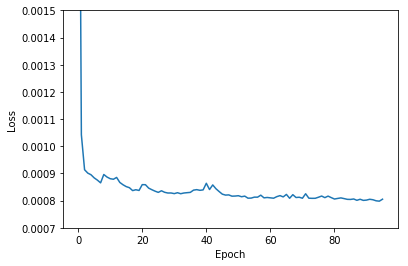

In [143]:
loss_list = np.array([h.history["loss"][0] for h in hist_list])
ax = plt.subplot(111)
ax.plot(loss_list)
ax.set_ylim(0.0007, 0.0015)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

In [169]:
model_file = os.path.join(data_dst, "lstm.h5")
model.save(model_file)

model_arch_file = os.path.join(data_src, "lstm.json")
with open(model_arch_file, "wb") as fp:
    fp.write(model.to_json().encode())

### Test the model

In [199]:
l = (1000 - (1000 % 3))
x = test_X[:l]
y = test_y[:l]
predict_y = model.predict(x, batch_size=3)
print("MSE", mean_squared_error(y, predict_y))

MSE 0.0017011209925


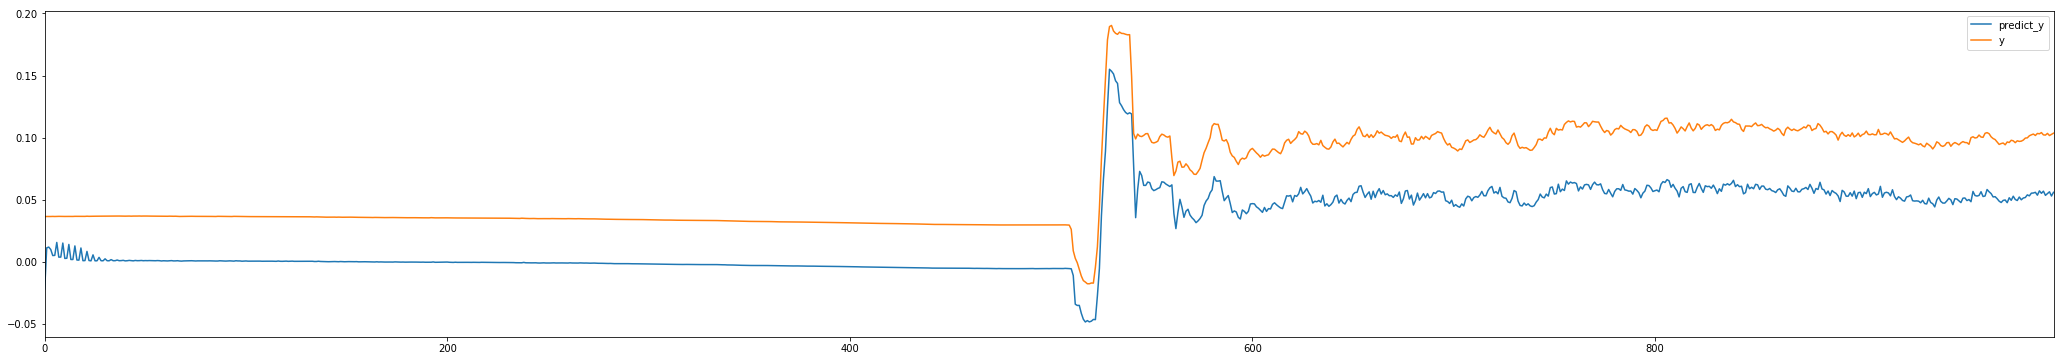

In [216]:
predict_y = predict_y.reshape((predict_y.shape[0],))
df_plot = pd.DataFrame({"y": y, "predict_y": predict_y})
df_plot.plot(figsize=(36,6))